In [1]:
!pip install vaderSentiment
!pip install pandas numpy nltk matplotlib scikit-learn vaderSentiment yfinance
!pip install --user tensorflow
!pip install --user keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from tensorflow import keras
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from transformers import pipeline
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


# Dataset (Tweets)


In [4]:
tweets = pd.read_csv('tweets.csv', encoding='latin1')
tweets = tweets.drop('Unnamed: 0', axis=1)
tweets.head()

,token,date,reply_count,like_count,retweet_count,quote_count,text
0,bitcoin,2022-01-01 00:00:00.000,20.0,207.0,31.0,3.0,Most people underestimate the impact #Bitcoin ...
1,bitcoin,2022-01-01 00:00:00.000,232.0,3405.0,286.0,27.0,#Bitcoin has started a new yearly candle https...
2,bitcoin,2022-01-01 00:00:00.000,2.0,861.0,12.0,0.0,@DESTROYBINARY did people forget that the amog...
3,bitcoin,2022-01-01 00:00:00.000,18.0,306.0,30.0,9.0,"In 2017, miners attempted to assert control ov..."
4,bitcoin,2022-01-01 00:00:00.000,35.0,721.0,35.0,1.0,Yearly Close \nMonthly Close\nDaily Close\n\nh...


##Pre-Trained Model FinBert on Tweets Dataset (Retrieving Sentiment Scores)

In [ ]:
import torch
import re
from transformers import BertTokenizer, BertForSequenceClassification

In [ ]:
# Check if CUDA is available
print(torch.cuda.is_available())  # Should return True if a GPU is available
print(torch.cuda.get_device_name(0))  # Returns the name of your GPU

True
Tesla T4


In [ ]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove mentions (@username) and hashtags (#hashtag)
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r"[^\w\s]", '', text)
    return text

tweets['cleaned_text'] = tweets['text'].apply(preprocess_text)

In [ ]:
# Load FinBERT tokenizer and model, and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone").to(device)
# Define labels
labels = {0: "neutral", 1: "positive", 2: "negative"}

In [ ]:
# Combined function for tokenization and sentiment prediction
def predict_sentiment(text):
    # Tokenize the text
    tokens = tokenizer(text, max_length=500, truncation=True, padding="max_length", return_tensors="pt").to(device)

    # Predict sentiment using FinBERT
    with torch.no_grad():
        outputs = model(**tokens)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)

        # Return the maximum sentiment score (positive sentiment score)
        sentiment_score = probabilities.max().cpu().numpy()
        return sentiment_score

# Apply the combined function to the 'text' column
tweets['sentiment_score'] = tweets['text'].apply(predict_sentiment)


In [ ]:
tweets.head()

,token,date,reply_count,like_count,retweet_count,quote_count,text,cleaned_text,sentiment_score
0,bitcoin,2022-01-01 00:00:00.000,20,207,31,3,Most people underestimate the impact #Bitcoin ...,Most people underestimate the impact Bitcoin w...,0.997812
1,bitcoin,2022-01-01 00:00:00.000,232,3405,286,27,#Bitcoin has started a new yearly candle https...,Bitcoin has started a new yearly candle,0.999996
2,bitcoin,2022-01-01 00:00:00.000,2,861,12,0,@DESTROYBINARY did people forget that the amog...,did people forget that the amogus meme was an...,0.999231
3,bitcoin,2022-01-01 00:00:00.000,18,306,30,9,"In 2017, miners attempted to assert control ov...",In 2017 miners attempted to assert control ove...,0.888492
4,bitcoin,2022-01-01 00:00:00.000,35,721,35,1,Yearly Close \nMonthly Close\nDaily Close\n\nh...,Yearly Close \nMonthly Close\nDaily Close\n\nh...,0.999803


#Pre-processing

In [ ]:
tweets = tweets.copy()

In [ ]:
tweets = tweets.drop(['token','reply_count','like_count','retweet_count', 'quote_count','text','cleaned_text'], axis=1)

In [ ]:
tweets.head()

,date,sentiment_score
0,2022-01-01 00:00:00.000,0.997812
1,2022-01-01 00:00:00.000,0.999996
2,2022-01-01 00:00:00.000,0.999231
3,2022-01-01 00:00:00.000,0.888492
4,2022-01-01 00:00:00.000,0.999803


In [ ]:
tweets['date'] = pd.to_datetime(tweets['date'])

In [ ]:
tweets['DateTime'] = tweets['date'].dt.floor('h')
tweets.head()

,date,sentiment_score,DateTime
0,2022-01-01,0.997812,2022-01-01
1,2022-01-01,0.999996,2022-01-01
2,2022-01-01,0.999231,2022-01-01
3,2022-01-01,0.888492,2022-01-01
4,2022-01-01,0.999803,2022-01-01


In [ ]:
vdf = tweets.groupby(pd.Grouper(key='date',freq='H')).size().reset_index(name='tweet_vol')
vdf.head(100)

,date,tweet_vol
0,2022-01-01 00:00:00,114
1,2022-01-01 01:00:00,0
2,2022-01-01 02:00:00,0
3,2022-01-01 03:00:00,0
4,2022-01-01 04:00:00,0
...,...,...
95,2022-01-04 23:00:00,0
96,2022-01-05 00:00:00,79
97,2022-01-05 01:00:00,0
98,2022-01-05 02:00:00,0


In [ ]:
vdf.index = pd.to_datetime(vdf.index)
vdf = vdf.set_index('date')
vdf.head()

,tweet_vol
date,
2022-01-01 00:00:00,114
2022-01-01 01:00:00,0
2022-01-01 02:00:00,0
2022-01-01 03:00:00,0
2022-01-01 04:00:00,0


In [ ]:
tweets.index = pd.to_datetime(tweets.index)
vdf['tweet_vol'] = vdf['tweet_vol'].astype(float)
tweets.head()

,date,sentiment_score,DateTime
1970-01-01 00:00:00.000000000,2022-01-01,0.997812,2022-01-01
1970-01-01 00:00:00.000000001,2022-01-01,0.999996,2022-01-01
1970-01-01 00:00:00.000000002,2022-01-01,0.999231,2022-01-01
1970-01-01 00:00:00.000000003,2022-01-01,0.888492,2022-01-01
1970-01-01 00:00:00.000000004,2022-01-01,0.999803,2022-01-01


In [ ]:
df = tweets.groupby('DateTime').agg(lambda x: x.mean())
df['Tweet_vol'] = vdf['tweet_vol']
df = df.drop(df.index[0])
df.head()

,date,sentiment_score,Tweet_vol
DateTime,,,
2022-01-02,2022-01-02,0.974126,73.0
2022-01-03,2022-01-03,0.984864,76.0
2022-01-04,2022-01-04,0.975889,61.0
2022-01-05,2022-01-05,0.964227,79.0
2022-01-06,2022-01-06,0.952694,88.0


In [ ]:
df=df.drop(['date'],axis=1)
df.tail()

,sentiment_score,Tweet_vol
DateTime,,
2023-06-18,0.979704,100.0
2023-06-19,0.963820,100.0
2023-06-20,0.987461,100.0
2023-06-21,0.974323,100.0
2023-06-22,0.979293,100.0




#Dataset (Bitcoin Historical Price)

In [ ]:
price = pd.read_csv('BTC-USD (2014-2024).csv', encoding='latin1')
price

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
1,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
2,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
3,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
4,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,2.412760e+07
...,...,...,...,...,...,...,...
3408,2024-01-17,43132.101563,43189.890625,42189.308594,42742.652344,42742.652344,2.085123e+10
3409,2024-01-18,42742.312500,42876.347656,40631.171875,41262.058594,41262.058594,2.521836e+10
3410,2024-01-19,41278.460938,42134.160156,40297.457031,41618.406250,41618.406250,2.575241e+10
3411,2024-01-20,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
price['Date'] = pd.to_datetime(price['Date'])
btc_data = price.set_index(pd.DatetimeIndex(price['Date']))
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0
2014-09-22,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0


In [ ]:
btc_data = btc_data.drop(['Date'], axis=1)
Final_df = pd.merge(df, btc_data, how='inner',left_index=True, right_index=True)
Final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 537 entries, 2022-01-02 to 2023-06-22
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sentiment_score  537 non-null    float64
 1   Tweet_vol        537 non-null    float64
 2   Open             537 non-null    float64
 3   High             537 non-null    float64
 4   Low              537 non-null    float64
 5   Close            537 non-null    float64
 6   Adj Close        537 non-null    float64
 7   Volume           537 non-null    float64
dtypes: float64(8)
memory usage: 37.8 KB


#Feature Engineering

In [ ]:
def SMA(df, periods=5):
    lst = []
    for i in range(len(df)):
        if i < periods:
            lst.append(np.nan)
        else:
            lst.append(round(np.mean(df[i:periods+i]), 2))

    return lst

def RSI(df, periods=5):
    df = df.diff()

    lst = []

    for i in range(len(df)):
        if i < periods or i==len(df)-1:
            lst.append(np.nan)
        else:
            avg_gain = (sum([x for x in df[i:periods+i] if x >= 0]) / periods)
            avg_loss = (sum([abs(x) for x in df[i:periods+i] if x <= 0]) / periods)
            if avg_loss==0:
                lst.append(np.nan)
            else:
                rs = avg_gain / avg_loss

                rsi = 100 - (100 / (1 + rs))

                lst.append(round(rsi, 2))
    return lst


In [ ]:
Final_df['RSI']=RSI(Final_df['Close'])
Final_df['SMA']=SMA(Final_df['Close'])
Final_df=Final_df[5:]

In [ ]:
Final_df[Final_df['RSI']==np.nan]['RSI']=Final_df['RSI'].mean()
Final_df['RSI'][-1]=Final_df['RSI'].mean()
Final_df.tail()

,sentiment_score,Tweet_vol,Open,High,Low,Close,Adj Close,Volume,RSI,SMA
2023-06-18,0.979704,100.0,26510.457031,26675.925781,26325.890625,26336.212891,26336.212891,9.565695e+09,92.730000,28290.86
2023-06-19,0.963820,100.0,26335.441406,26984.611328,26312.832031,26851.029297,26851.029297,1.282699e+10,96.980000,28779.52
2023-06-20,0.987461,100.0,26841.664063,28388.968750,26668.791016,28327.488281,28327.488281,2.221186e+10,96.510000,29422.36
2023-06-21,0.974323,100.0,28311.310547,30737.330078,28283.410156,30027.296875,30027.296875,3.334676e+10,93.660000,29969.79
2023-06-22,0.979293,100.0,29995.935547,30495.998047,29679.158203,29912.281250,29912.281250,2.065316e+10,48.562288,29912.28


In [ ]:
RSI=Final_df['RSI'].mean()
for i in range(len(Final_df)):
    if np.isnan(Final_df['RSI'][i]):
        Final_df['RSI'][i]=RSI

Final_df.head()

,sentiment_score,Tweet_vol,Open,High,Low,Close,Adj Close,Volume,RSI,SMA
2022-01-07,0.982538,77.0,43153.570313,43153.570313,41077.445313,41557.902344,41557.902344,8.419661e+10,42.82,41952.11
2022-01-08,0.976378,58.0,41561.464844,42228.941406,40672.277344,41733.941406,41733.941406,2.806636e+10,96.49,42430.35
2022-01-09,0.977678,73.0,41734.726563,42663.949219,41338.160156,41911.601563,41911.601563,2.129438e+10,61.42,42601.88
2022-01-10,0.979264,74.0,41910.230469,42199.484375,39796.570313,41821.261719,41821.261719,3.210423e+10,64.55,42839.50
2022-01-11,0.965574,61.0,41819.507813,43001.156250,41407.753906,42735.855469,42735.855469,2.632765e+10,66.66,43110.73


#Analysis

In [ ]:
cor = Final_df.corr()
cor

,sentiment_score,Tweet_vol,Open,High,Low,Close,Adj Close,Volume,RSI,SMA
sentiment_score,1.000000,0.031575,0.055962,0.051937,0.072172,0.065487,0.065487,-0.217793,0.098709,0.074012
Tweet_vol,0.031575,1.000000,-0.660318,-0.662844,-0.655565,-0.660430,-0.660430,0.024275,-0.002096,-0.657710
Open,0.055962,-0.660318,1.000000,0.997756,0.997015,0.994386,0.994386,-0.032026,-0.134456,0.987146
High,0.051937,-0.662844,0.997756,1.000000,0.996393,0.997453,0.997453,-0.014237,-0.115363,0.990341
Low,0.072172,-0.655565,0.997015,0.996393,1.000000,0.997465,0.997465,-0.065952,-0.116966,0.990325
Close,0.065487,-0.660430,0.994386,0.997453,0.997465,1.000000,1.000000,-0.043563,-0.095671,0.993053
Adj Close,0.065487,-0.660430,0.994386,0.997453,0.997465,1.000000,1.000000,-0.043563,-0.095671,0.993053
Volume,-0.217793,0.024275,-0.032026,-0.014237,-0.065952,-0.043563,-0.043563,1.000000,-0.092751,-0.054591
RSI,0.098709,-0.002096,-0.134456,-0.115363,-0.116966,-0.095671,-0.095671,-0.092751,1.000000,-0.018628
SMA,0.074012,-0.657710,0.987146,0.990341,0.990325,0.993053,0.993053,-0.054591,-0.018628,1.000000


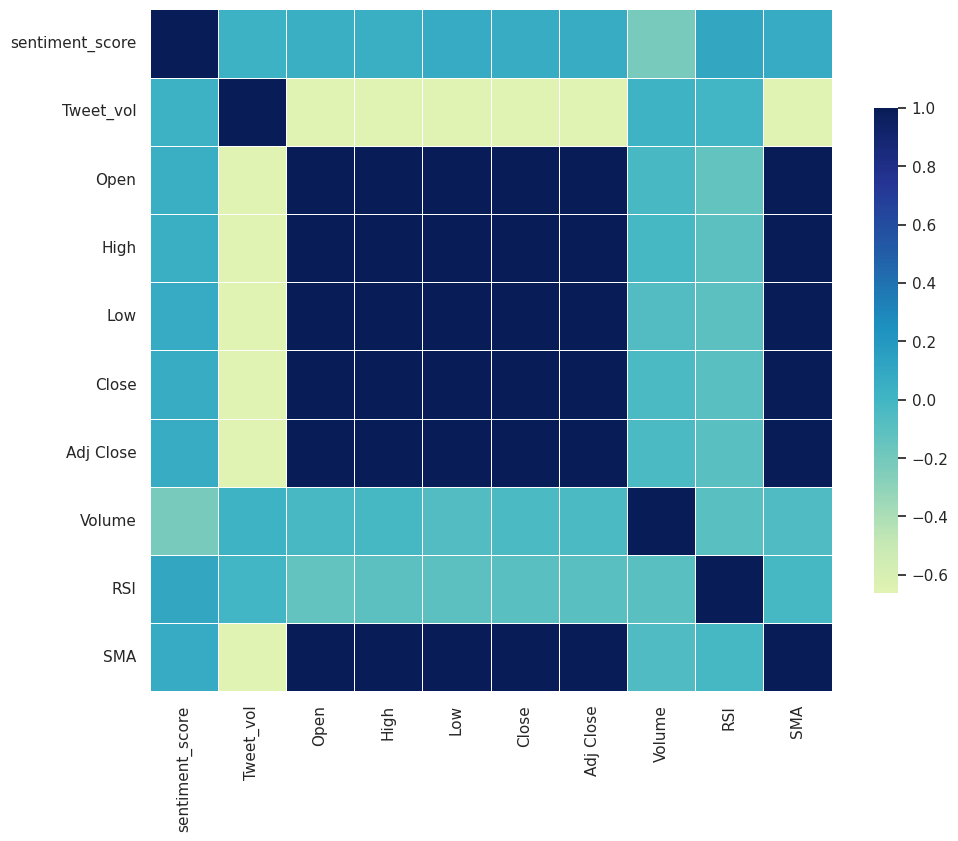

In [ ]:
import matplotlib.pyplot as plt
sns.set(style="white")
f, ax = plt.subplots(figsize=(11, 9))

ax =sns.heatmap(cor, cmap="YlGnBu", vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

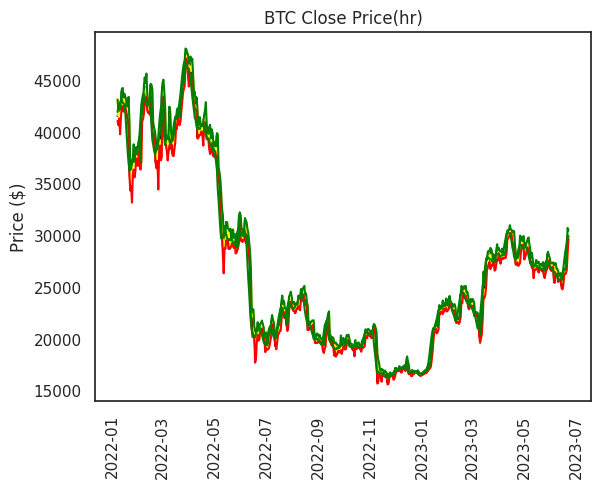

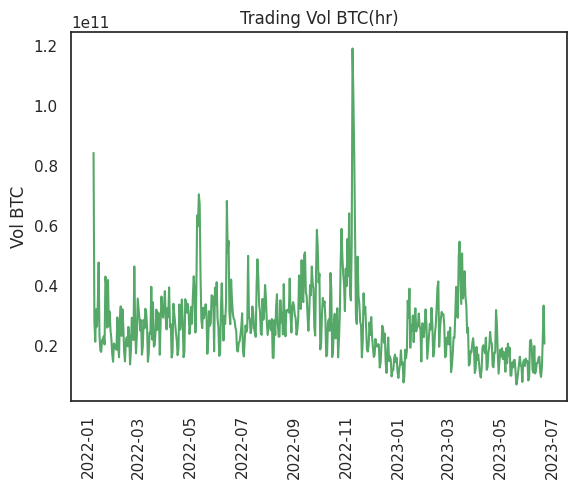

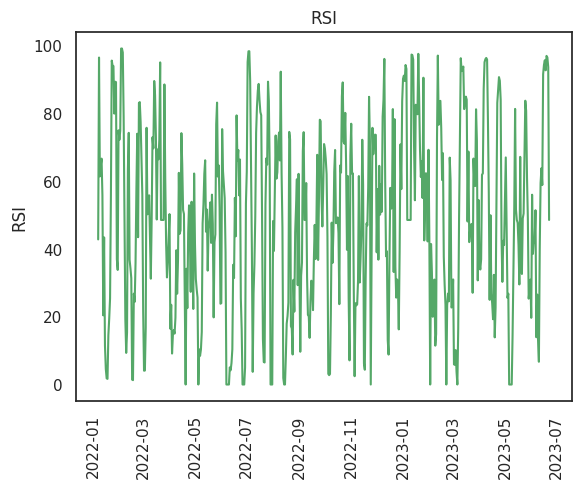

In [ ]:
plt.plot(Final_df.index, Final_df['Close'], 'black')
plt.plot(Final_df.index, Final_df['Open'], 'yellow')
plt.plot(Final_df.index, Final_df['Low'], 'red')
plt.plot(Final_df.index, Final_df['High'], 'green')
plt.plot(Final_df.index, Final_df['SMA'], 'green')
plt.title('BTC Close Price(hr)')
plt.xticks(rotation='vertical')
plt.ylabel('Price ($)');
plt.show();

plt.plot(Final_df.index, Final_df['Volume'], 'g')
plt.title('Trading Vol BTC(hr)')
plt.xticks(rotation='vertical')
plt.ylabel('Vol BTC');
plt.show();

plt.plot(Final_df.index, Final_df['RSI'], 'g')
plt.title('RSI')
plt.xticks(rotation='vertical')
plt.ylabel('RSI');
plt.show();

#LSTM & LSTM-RF

In [ ]:
df = Final_df.copy()
df = df.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)
df.head()

,sentiment_score,Tweet_vol,Close,Volume,RSI,SMA
2022-01-07,0.982538,77.0,41557.902344,8.419661e+10,42.82,41952.11
2022-01-08,0.976378,58.0,41733.941406,2.806636e+10,96.49,42430.35
2022-01-09,0.977678,73.0,41911.601563,2.129438e+10,61.42,42601.88
2022-01-10,0.979264,74.0,41821.261719,3.210423e+10,64.55,42839.50
2022-01-11,0.965574,61.0,42735.855469,2.632765e+10,66.66,43110.73


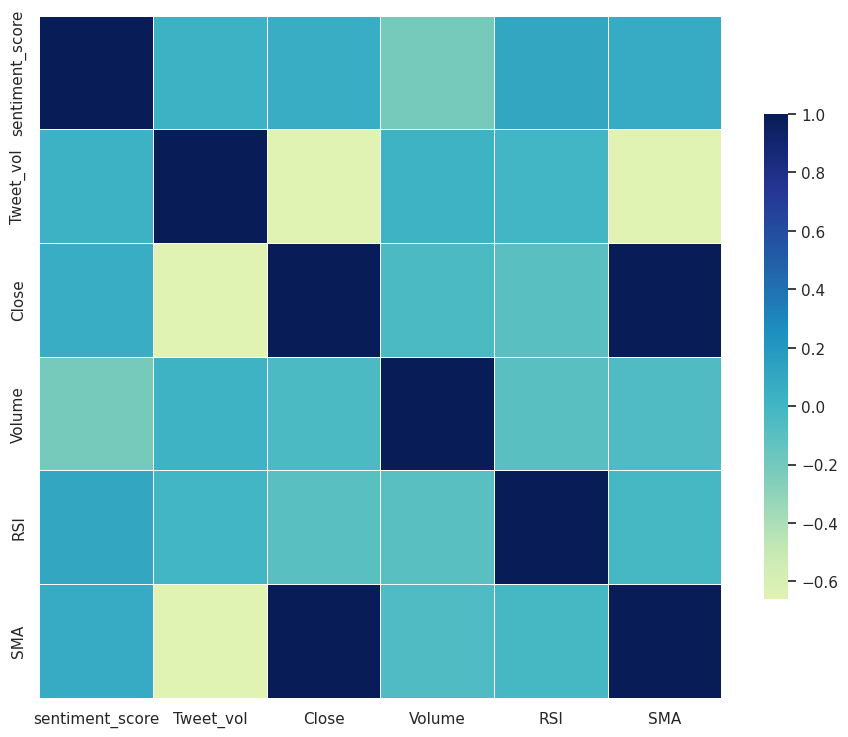

In [ ]:
cor = df.corr()
import matplotlib.pyplot as plt
sns.set(style="white")
f, ax = plt.subplots(figsize=(11, 9))

ax =sns.heatmap(cor, cmap="YlGnBu", vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
##PREPARE DATA
from math import sqrt
from pandas import DataFrame
from pandas import concat

features = df[['sentiment_score', 'Tweet_vol', 'Volume']].values
target = df['Close'].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

n_hours = 3
n_features = 7
n_obs = n_hours*n_features

In [ ]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
3,0.723078,0.124661,0.813506,0.689177,0.431827,0.840984,0.615276,0.073171,0.819063,0.187779,...,0.824672,0.127287,0.619403,0.862283,0.665786,0.116531,0.821820,0.223849,0.650968,0.870072
4,0.615276,0.073171,0.819063,0.187779,0.973074,0.856660,0.638026,0.113821,0.824672,0.127287,...,0.821820,0.223849,0.650968,0.870072,0.426222,0.081301,0.850691,0.172248,0.672247,0.878963
5,0.638026,0.113821,0.824672,0.127287,0.619403,0.862283,0.665786,0.116531,0.821820,0.223849,...,0.850691,0.172248,0.672247,0.878963,0.605759,0.094851,0.888990,0.236316,0.563433,0.881442
6,0.665786,0.116531,0.821820,0.223849,0.650968,0.870072,0.426222,0.081301,0.850691,0.172248,...,0.888990,0.236316,0.563433,0.881442,0.592818,0.127371,0.846136,0.363083,0.205829,0.870306
7,0.426222,0.081301,0.850691,0.172248,0.672247,0.878963,0.605759,0.094851,0.888990,0.236316,...,0.846136,0.363083,0.205829,0.870306,0.005733,0.059621,0.862177,0.147681,0.437777,0.868890


In [ ]:
reframed.values

array([[0.72307759, 0.12466125, 0.81350638, ..., 0.22384876, 0.65096813,
        0.87007241],
       [0.61527561, 0.07317073, 0.81906344, ..., 0.17224796, 0.67224687,
        0.87896336],
       [0.63802575, 0.11382114, 0.82467168, ..., 0.23631626, 0.56343284,
        0.88144154],
       ...,
       [0.66725055, 0.18699187, 0.3385075 , ..., 0.13548262, 0.97327551,
        0.43025703],
       [0.6734786 , 0.18699187, 0.33300019, ..., 0.23494796, 0.94453409,
        0.44820185],
       [0.395524  , 0.18699187, 0.34925151, ..., 0.12155915, 0.48973667,
        0.44631666]])

In [ ]:
values = reframed.values
n_train_hours = 200
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(200, 24)

In [ ]:
# split into input and outputs
X_train, y_train = train[:, :n_obs], train[:, -n_features]
X_test, y_test = test[:, :n_obs], test[:, -n_features]

X_train = X_train.reshape((X_train.shape[0], n_hours, n_features))
X_test = X_test.reshape((X_test.shape[0], n_hours, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(200, 3, 7) (200,) (329, 3, 7) (329,)


In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.5398 - val_loss: 0.1171
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2863 - val_loss: 0.4263
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1990 - val_loss: 0.4514
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1804 - val_loss: 0.3128
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1826 - val_loss: 0.3675
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1665 - val_loss: 0.3889
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1557 - val_loss: 0.3231
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1414 - val_loss: 0.3708
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1419 - val_loss: 0.2956
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1465 - val_loss: 0.2561
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1211 - val_loss: 0.3136
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1040 - val_loss: 0.2342
E

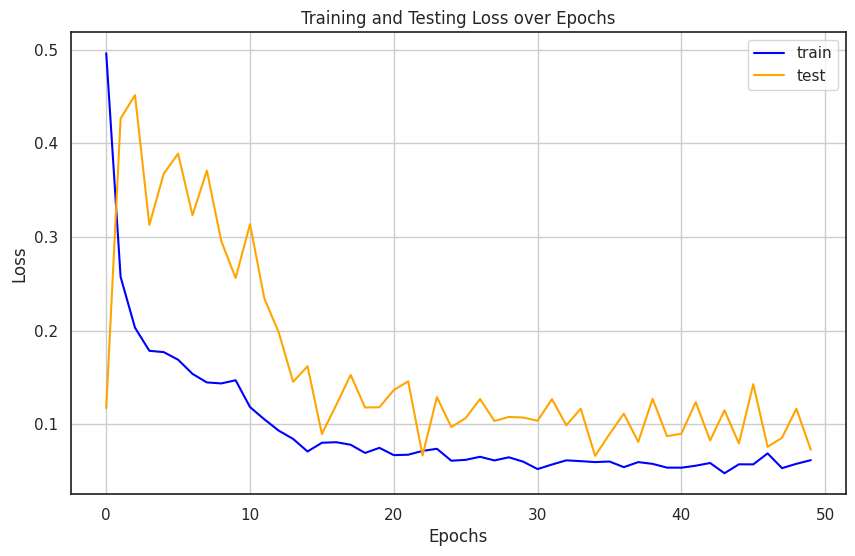

In [ ]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='train', color='blue')
plt.plot(test_loss, label='test', color='orange')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

(329, 3, 7) (329,) (200, 3, 7) (200,)


#Evaluation Model

In [ ]:
##Evaluating model

y_pred = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
# LSTM Model
y_scaler = MinMaxScaler()
y_scaler.fit(y_train.reshape(-1, 1))

y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
# Evaluate performance
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'LSTM MAE: {mse}')
# Calculate RMSE
rmse = sqrt(mse)
print('LSTM RMSE: %.3f' % rmse)


# LSTM-RF Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(y_pred, y_test)

# Predict with Random Forest
rf_predictions = rf_model.predict(y_pred)

# Evaluate performance
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f"LSTM-RF MAE: {rf_mse}")
# Calculate LSTM-RF RMSE
rf_rmse = sqrt(rf_mse)
print('LSTM-RF RMSE: %.3f' % rf_rmse)


LSTM MAE: 0.005518890412117189
LSTM RMSE: 0.074
LSTM-RF MAE: 0.0002988117005923893
LSTM-RF RMSE: 0.017


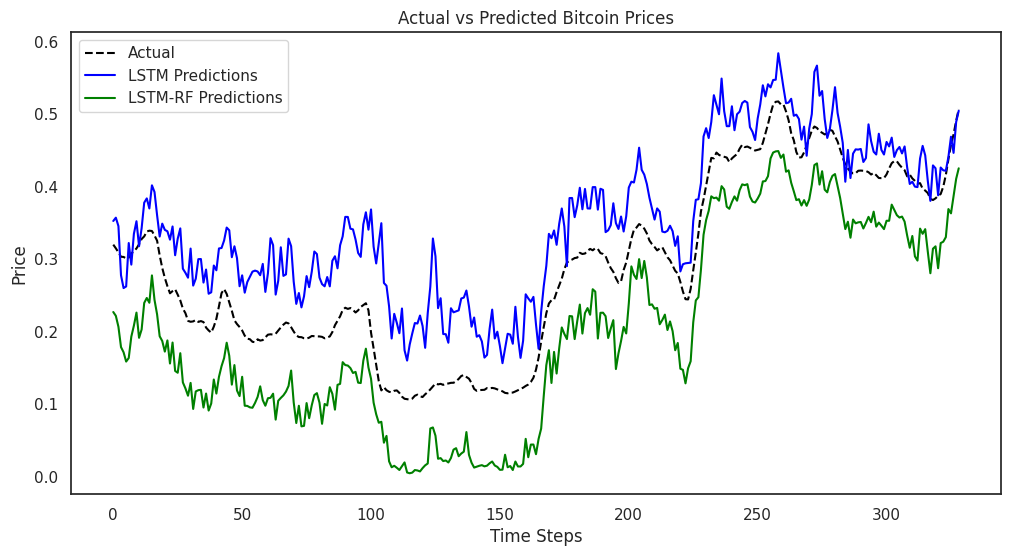

In [ ]:
# Plot Actual vs Predicted Prices for LSTM and LSTM-RF
plt.figure(figsize=(12, 6))

# Plot Actual Values
plt.plot(y_test_inv, label='Actual', color='black', linestyle='--')

# Plot LSTM Predictions
plt.plot(y_pred_inv, label='LSTM Predictions', color='blue')

# Plot LSTM-RF Predictions
plt.plot(rf_predictions, label='LSTM-RF Predictions', color='green')

# Add titles and labels
plt.title('Actual vs Predicted Bitcoin Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()